In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import strategy.betting_logic as betting_logic
from data.data_prep import DataPrep
from pipelines.preprocessing import preprocess_pipeline
from model.train import train_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from backtest import cross_validate
import os

from pipelines.pipeline import get_features_and_model_pipeline
path = r"c:\Users\brtnl\OneDrive\Desktop\code\sports_betting"
os.chdir(path)

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
print("Step 1: Loading data...")
data_prep = DataPrep(dataset="cfb")
raw_data = data_prep.get_data()

print("Step 2: Preprocess and separate odds, X, and y...")
preprocessed_data = preprocess_pipeline().fit_transform(raw_data)
target_col = "total"
betting_cols = ["min_ou", "max_ou"]

odds_df = preprocessed_data[[target_col] + betting_cols]
odds_df["pred"] = None
X = preprocessed_data.drop(columns=[target_col])
y = preprocessed_data[target_col]

Step 1: Loading data...
Step 2: Preprocess and separate odds, X, and y...


C:\Users\brtnl\AppData\Local\Temp\ipykernel_33300\2007525662.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odds_df["pred"] = None


In [13]:
type(pipeline)

sklearn.pipeline.Pipeline

In [7]:
# TODO: replace feature importance with a graph
print("Step 3: Training and evaluating the model...")
pipeline = get_features_and_model_pipeline()
model, odds_df = cv2(X, y, pipeline, odds_df, betting_logic.simple_percentage)

Step 3: Training and evaluating the model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4633
[LightGBM] [Info] Number of data points in the train set: 7756, number of used features: 38
[LightGBM] [Info] Start training from score 55.495101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4697
[LightGBM] [Info] Number of data points in the train set: 9310, number of used features: 38
[LightGBM] [Info] Start training from score 55.715038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4737
[LightGBM] 

c:\Users\brtnl\OneDrive\Desktop\code\sports_betting\src\cfb\strategy\betting_logic.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[condition, "unit_pnl"] = value


In [ ]:
pipeline[:-1].fit_transform(X, y).columns

Index(['home_classification_fbs', 'home_classification_fcs',
       'home_classification_ii', 'home_classification_iii',
       'home_classification_None', 'away_classification_fbs',
       'away_classification_fcs', 'away_classification_ii',
       'away_classification_iii', 'away_classification_None',
       'season_type_postseason', 'season_type_regular',
       'season_type_spring_postseason', 'season_type_spring_regular',
       'attendance', 'home_pregame_elo', 'away_pregame_elo', 'dome', 'grass',
       'season', 'week', 'neutral_site', 'conference_game', 'home_points',
       'home_postgame_win_probability', 'home_postgame_elo', 'away_points',
       'away_postgame_win_probability', 'away_postgame_elo',
       'excitement_index', 'capacity', 'elevation', 'constructionyear',
       'min_ou', 'max_ou', 'home_days_since_last_game',
       'away_days_since_last_game', 'home_rolling_3_mean_points_for',
       'away_rolling_3_mean_points_for', 'home_rolling_5_mean_points_for',
      

In [ ]:
pipeline[:-1].predict()

In [ ]:
from sklearn.model_selection import BaseCrossValidator
import numpy as np

class RollingTimeSeriesSplit(BaseCrossValidator):
    """
    Custom rolling cross-validator that expands the training set season by season.
    """

    def __init__(self, seasons, init_train_yrs=5):
        self.seasons = seasons
        self.init_train_yrs = init_train_yrs
        self.unique_seasons = sorted(seasons.unique())

    def split(self, X, y=None, groups=None):
        """Yields indices for train-test splits."""
        for i in range(self.init_train_yrs, len(self.unique_seasons)):
            train_seasons = self.unique_seasons[:i]
            test_season = self.unique_seasons[i]

            train_idx = np.where(self.seasons.isin(train_seasons))[0]
            test_idx = np.where(self.seasons == test_season)[0]

            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splits."""
        return len(self.unique_seasons) - self.init_train_yrs


def cv2(X, y, pipeline, odds_df, betting_fnc=None, init_train_yrs=5, file_name=None):
    cv = RollingTimeSeriesSplit(seasons=X["season"], init_train_yrs=init_train_yrs)
    for train_idx, test_idx in cv.split(X, y):
        # Train-test split
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test = X.iloc[test_idx]
        pipeline.fit(X_train, y_train)

        # Get predictions
        preds = pipeline.predict(X_test)
        odds_df.iloc[test_idx, odds_df.columns.get_loc("pred")] = preds
    odds_df = betting_fnc(odds_df)
    return pipeline, odds_df

In [9]:
odds_df[odds_df['unit_pnl'].notna()]
odds_df

,total,min_ou,max_ou,pred,unit_pnl
id,,,,,
332412309,27.0,NaN,NaN,None,NaN
332412579,37.0,56.0,56.0,None,NaN
332410154,38.0,NaN,NaN,None,NaN
332412710,51.0,NaN,NaN,None,NaN
332410084,108.0,NaN,NaN,None,NaN
...,...,...,...,...,...
401741208,66.0,NaN,NaN,59.858436,NaN
401680057,67.0,58.5,58.5,59.600513,NaN
401677189,51.0,45.5,46.0,53.919714,0.87


In [ ]:
pipeline.

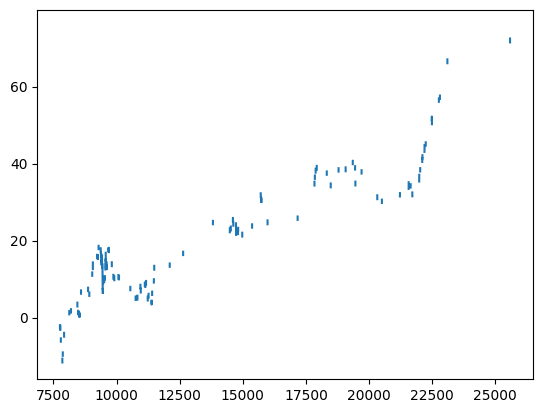

In [10]:
plt.plot(odds_df.reset_index()["unit_pnl"].cumsum())